In [4]:
!pip install pyathena


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [5]:
#Libraries
from pyathena import connect
import pandas as pd
import datetime as dt
import numpy as np

In [6]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name = 'analytics'
table1_name = 'daily_sales_not_cancellations'
table2_name = 'daily_tx_not_cancellations'

In [7]:
#Connection

conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')
df1 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table1_name};', conn)
df2 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table2_name};', conn)

/tmp/ipykernel_1973/835893596.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table1_name};', conn)
/tmp/ipykernel_1973/835893596.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table2_name};', conn)


In [8]:
df = df1.merge(df2, on=['date', 'payer', 'country'], how='outer')

In [9]:
df.shape

(103726, 5)

In [10]:
df.amount.sum()

25110624454.4149

In [16]:
df.head()

,payer,country,date,amount
0,BANCOPPEL (BTS),MEXICO,2021-01-13,1234299.06
1,DAVIVIENDA - HONDURAS (BTS),HONDURAS,2021-07-05,1519.00
2,BANCO DE GUAYAQUIL,ECUADOR,2021-04-13,11275.00
3,CARIBE EXPRESS,DOMINICAN REPUBLIC,2021-04-13,323943.00
4,INTERMEX,MEXICO,2021-04-13,153547.27


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103726 entries, 0 to 103725
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   payer    103726 non-null  object 
 1   country  103726 non-null  object 
 2   date     103726 non-null  object 
 3   amount   103726 non-null  float64
 4   count    103726 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 4.0+ MB


In [12]:
# Excluding 'EXPIRED ORDERS'
df = df[df['payer']!='EXPIRED ORDERS']

In [13]:
# Excluding sales amount == 0
df = df[df['amount']!= 0 ]

In [14]:
# Combining payer and country, we can obtain a column to work on 
# We can enconde it to obtain better results
from sklearn.preprocessing import LabelEncoder
df['payer_country'] = df['payer'] + '_' + df['country']

# Inicializar LabelEncoder
label_encoder = LabelEncoder()
# Codificar ‘PAYER_COUNTRY’ como valores numéricos únicos
df['payer_country_encoder'] = label_encoder.fit_transform(df['payer_country'])

In [20]:
df.head()

,payer,country,date,amount,payer_country,payer_country_encoder
0,BANCOPPEL (BTS),MEXICO,2021-01-13,1234299.06,BANCOPPEL (BTS)_MEXICO,35
1,DAVIVIENDA - HONDURAS (BTS),HONDURAS,2021-07-05,1519.00,DAVIVIENDA - HONDURAS (BTS)_HONDURAS,66
2,BANCO DE GUAYAQUIL,ECUADOR,2021-04-13,11275.00,BANCO DE GUAYAQUIL_ECUADOR,22
3,CARIBE EXPRESS,DOMINICAN REPUBLIC,2021-04-13,323943.00,CARIBE EXPRESS_DOMINICAN REPUBLIC,55
4,INTERMEX,MEXICO,2021-04-13,153547.27,INTERMEX_MEXICO,96


In [ ]:
##NUMBER OF PAYERS PER MONTH AND YEAR##

/tmp/ipykernel_1973/3651419868.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['date'].dt.year
/tmp/ipykernel_1973/3651419868.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['date'].dt.month


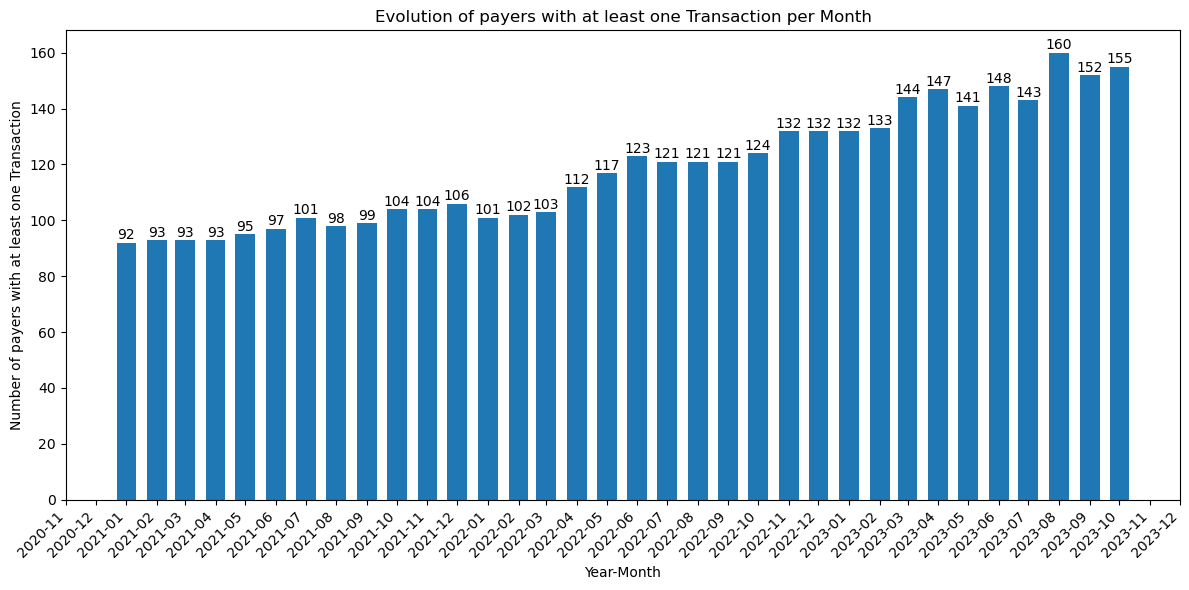

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_evolution_of_payers(data, start_date, end_date):
    """
    Plots the evolution of unique payers with at least one transaction per month.

    Parameters:
    - data (pd.DataFrame): DataFrame containing columns 'date' and 'payer_country'.
    - start_date (str): Start date in 'YYYY-MM-DD' format.
    - end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
    None (displays the plot).
    """
    # Convert the 'date' column to datetime format
    data['date'] = pd.to_datetime(data['date'])

    # Filter by dates
    mask = (data['date'] >= start_date) & (data['date'] <= end_date)
    df = data[mask]

    # Create new columns for year and month
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

    # Get unique payers per month
    monthly_unique_payers = df.groupby(['year', 'month'])['payer_country'].nunique().reset_index(name='count')

    # Create a custom index based on 'year' and 'month'
    monthly_unique_payers['date'] = pd.to_datetime(monthly_unique_payers[['year', 'month']].assign(day=1))

    # Create the bar plot with custom x-axis index
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(monthly_unique_payers['date'], monthly_unique_payers['count'], width=20)

    # Format x-axis labels as 'YYYY-MM'
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    # Add numbers above the bars
    for i, v in enumerate(monthly_unique_payers['count']):
        ax.text(monthly_unique_payers['date'][i], v + 0.1, str(v), ha='center', va='bottom')

    plt.xlabel('Year-Month')
    plt.ylabel('Number of payers with at least one Transaction')
    plt.title('Evolution of payers with at least one Transaction per Month')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



# Define start and end dates
start_date = '2021-01-01'
end_date = '2023-10-31'

# Call the function
plot_evolution_of_payers(df, start_date, end_date)

In [16]:
####HOW MANY DIFFERENT PAYERS ARE THERE IN THE PERIOD?##
df.payer_country.nunique()

231

In [17]:
##PAYERS "EXPIRED ORDERS" ARE EXCLUDED, DEFINE THEIR TREATMENT##
df.payer_country.unique()

array(['MASTERCARD ATM NETWORK_UNITED STATES', 'INTERBANK_PERU',
       'CREDOMATIC (BTS)_NICARAGUA',
       'MICOOPE-FENACOAC (RED CHAPINA)_GUATEMALA',
       'EMPENOS DEL SUR (ANTERIOR BALSAS)_MEXICO',
       'CUSCA (CITI - RECIBA NETWORKS)_EL SALVADOR',
       'VIAMERICAS USA DEPOSITS_UNITED STATES',
       'BANCO GANADERO (BOLIVIA)_BOLIVIA', 'NAFA_TOGO',
       'BANCO DAYCOVAL_BRAZIL', 'CHEDRAUI (APPRIZA)_MEXICO',
       'TELEDOLAR-NIC (TN)_NICARAGUA',
       'BANCO DAVIVIENDA SALVADORENO (BTS)_EL SALVADOR',
       'ECUAGIROS_ECUADOR', 'COOPERATIVA CACIL (UT)_HONDURAS',
       'BANCO BHD LEON_DOMINICAN REPUBLIC', 'BANCOPPEL (APPRIZA)_MEXICO',
       'BANCO DE GUAYAQUIL_ECUADOR', 'BANCO BISA_BOLIVIA',
       'GRUPO EXITO (TN)_COLOMBIA', 'ELEKTRA (BTS)_HONDURAS',
       'INTERMEX_MEXICO', 'BANHCAFE_HONDURAS',
       'G Y T CONTINENTAL_GUATEMALA', 'BANRURAL (RYT)_GUATEMALA',
       'INPAMEX-DEPOSIT - INSTANT PAY DE MEXICO_MEXICO',
       'EASY PAGOS_ECUADOR', 'COOPERATIVA FRONTERIZA (

In [226]:
##WE OBTAIN, AGE, ACTIVE TIME, INACTIVE TIME, AMOUNT TRADED AND TRANSACTIONS PER PAYER (JANUARY 2021-OCTOBER 2023)##

In [18]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Find the first and last date per 'payer_country' and calculate total_amount and count
result = (
    df.groupby('payer_country')
    .agg(
        first_date=('date', 'min'),
        last_date=('date', 'max'),
        total_amount=('amount', 'sum'),
        total_transactions=('count', 'sum')  # Add this line for total_transactions
    )
    .reset_index()
)

# Calculate the 'age_payer' variable accurately
result['age_payer'] = ((pd.to_datetime('2023-10-21') - result['first_date']).dt.days / 30).round(2)

# Calculate the 'active_payer' variable
result['active_time'] = ((result['last_date'] - result['first_date']).dt.days / 30).round(2)

# Calculate the 'inactive' variable
result['inactive_time'] = ((pd.to_datetime('2023-10-21') - result['last_date']).dt.days / 30).round(2)

# Sort the final DataFrame by 'total_amount' from highest to lowest
result = result.sort_values(by='total_amount', ascending=False)

# Display the result
pd.set_option('display.max_columns', None)
print(result)

                      payer_country first_date  last_date  total_amount  \
76          ELEKTRA (MEXICO)_MEXICO 2020-12-31 2023-10-21  6.397947e+09   
34       BANCOPPEL (APPRIZA)_MEXICO 2021-06-05 2023-10-21  3.345583e+09   
42         BANRURAL (RYT)_GUATEMALA 2020-12-31 2023-10-21  2.928455e+09   
29       BANCO INDUSTRIAL_GUATEMALA 2020-12-31 2023-10-21  2.286921e+09   
45     BBVA - BANCOMER (BTS)_MEXICO 2020-12-31 2023-10-21  6.632710e+08   
..                              ...        ...        ...           ...   
120                MFS AFRICA_GHANA 2023-06-19 2023-06-19  5.000000e+00   
147  RED CHAPINA ANYWHERE_GUATEMALA 2023-08-23 2023-08-23  2.000000e+00   
225           WOOLWORTH (UT)_MEXICO 2023-09-15 2023-09-15  1.000000e+00   
139                 NAIRAGRAM_KENYA 2023-07-13 2023-07-13  1.000000e+00   
213               TRANSPAY_MALAYSIA 2023-10-02 2023-10-02  1.000000e+00   

     total_transactions  age_payer  active_time  inactive_time  
76             14707864      34.13

In [390]:
###TABULATION OF PAYERS BY AGE##
##NOTAR QUE AQUI INCLUSO PUEDE HABER PAYERS NO ACTIVOS A HOY##

/tmp/ipykernel_1973/3446246293.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = result.groupby('age_group')['payer_country'].count()


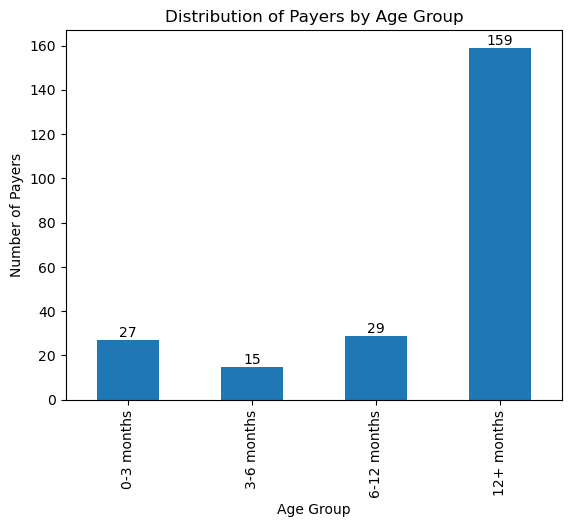

In [19]:
# Define the boundaries of age groups
bins = [0, 3, 6, 12, float('inf')]

# Create a new column 'age_group' in the result DataFrame
result['age_group'] = pd.cut(result['age_payer'], bins, labels=['0-3 months', '3-6 months', '6-12 months', '12+ months'])

# Group by 'age_group' and count the number of 'payer_country' in each group
grouped_data = result.groupby('age_group')['payer_country'].count()

# Create the bar plot
fig, ax = plt.subplots()
bars = grouped_data.plot(kind='bar', ax=ax)

# Display the count values on top of each bar
for bar in bars.patches:
    yval = bar.get_height()
    xval = bar.get_x() + bar.get_width() / 2
    ax.text(xval, yval + 0.1, int(yval), ha='center', va='bottom')

# Labeling and title of the plot
plt.xlabel('Age Group')
plt.ylabel('Number of Payers')
plt.title('Distribution of Payers by Age Group')

# Show the plot
plt.show()

In [ ]:
##TABULATION OF PAYERS BY LENGTH OF TIME IN OPERATION##

/tmp/ipykernel_1973/1589590665.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = result.groupby('active_time_group')['payer_country'].count()


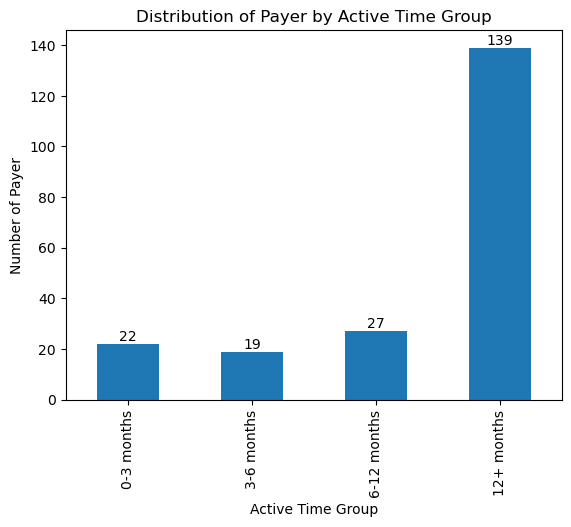

In [20]:
# Define the boundaries of age groups
bins = [0, 3, 6, 12, float('inf')]

# Create a new column 'age_group' in the result DataFrame
result['active_time_group'] = pd.cut(result['active_time'], bins, labels=['0-3 months', '3-6 months', '6-12 months', '12+ months'])

# Group by 'age_group' and count the number of 'payer_country' in each group
grouped_data = result.groupby('active_time_group')['payer_country'].count()

# Create the bar plot
fig, ax = plt.subplots()
bars = grouped_data.plot(kind='bar', ax=ax)

# Display the count values on top of each bar
for bar in bars.patches:
    yval = bar.get_height()
    xval = bar.get_x() + bar.get_width() / 2
    ax.text(xval, yval + 0.1, int(yval), ha='center', va='bottom')

# Labeling and title of the plot
plt.xlabel('Active Time Group')
plt.ylabel('Number of Payer')
plt.title('Distribution of Payer by Active Time Group')

# Show the plot
plt.show()

In [37]:
result.active_time_group.value_counts()

active_time_group
12+ months     139
6-12 months     27
0-3 months      22
3-6 months      19
Name: count, dtype: int64

In [38]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231 entries, 76 to 213
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   payer_country        231 non-null    object        
 1   first_date           231 non-null    datetime64[ns]
 2   last_date            231 non-null    datetime64[ns]
 3   total_amount         231 non-null    float64       
 4   total_transactions   231 non-null    int64         
 5   age_payer            231 non-null    float64       
 6   active_time          231 non-null    float64       
 7   inactive_time        231 non-null    float64       
 8   age_group            230 non-null    category      
 9   active_time_group    207 non-null    category      
 10  inactive_time_group  118 non-null    category      
dtypes: category(3), datetime64[ns](2), float64(4), int64(1), object(1)
memory usage: 17.5+ KB


In [39]:
result.tail()

,payer_country,first_date,last_date,total_amount,total_transactions,age_payer,active_time,inactive_time,age_group,active_time_group,inactive_time_group
120,MFS AFRICA_GHANA,2023-06-19,2023-06-19,5.0,1,4.13,0.0,4.13,3-6 months,NaN,3-6 months
147,RED CHAPINA ANYWHERE_GUATEMALA,2023-08-23,2023-08-23,2.0,2,1.97,0.0,1.97,0-3 months,NaN,0-3 months
225,WOOLWORTH (UT)_MEXICO,2023-09-15,2023-09-15,1.0,1,1.20,0.0,1.20,0-3 months,NaN,0-3 months
139,NAIRAGRAM_KENYA,2023-07-13,2023-07-13,1.0,1,3.33,0.0,3.33,3-6 months,NaN,3-6 months
213,TRANSPAY_MALAYSIA,2023-10-02,2023-10-02,1.0,1,0.63,0.0,0.63,0-3 months,NaN,0-3 months


In [40]:
##14 14 PAYERS OPERATED ONLY ONE DAY IN THE LAST 34 MONTHS##
##NOTAR QUE ESTOS 14 CASOS NO ESTABAN EN EL GRAFICO DE BARRAS DE ARRIBA (ACTIVE_TIME_GROUP=NaN) Y MONTOS DEL PERIODO MUY BAJOS

control=result.loc[result.active_time==0]
control.head(14)

,payer_country,first_date,last_date,total_amount,total_transactions,age_payer,active_time,inactive_time,age_group,active_time_group,inactive_time_group
56,CASHWAY_NEPAL,2023-04-22,2023-04-22,2311.00,1,6.07,0.0,6.07,6-12 months,NaN,6-12 months
137,NAFA_SIERRA LEONE,2022-07-02,2022-07-02,1000.00,1,15.87,0.0,15.87,12+ months,NaN,12+ months
175,TRANSFERTO - THUNES_GREECE,2022-06-07,2022-06-07,980.00,1,16.70,0.0,16.70,12+ months,NaN,12+ months
92,INPAGUA - INSTANT PAY DE GUATEMALA_GUATEMALA,2021-06-15,2021-06-15,700.00,1,28.60,0.0,28.60,12+ months,NaN,12+ months
216,TRANSPAY_THAILAND,2023-10-21,2023-10-21,500.00,1,0.00,0.0,0.00,NaN,NaN,NaN
188,TRANSFERTO - THUNES_POLAND,2023-09-08,2023-09-08,200.00,1,1.43,0.0,1.43,0-3 months,NaN,0-3 months
186,TRANSFERTO - THUNES_NORWAY,2023-09-06,2023-09-06,110.51,1,1.50,0.0,1.50,0-3 months,NaN,0-3 months
203,TRANSFERTO - THUNES_ZIMBABWE,2023-04-26,2023-04-26,100.00,1,5.93,0.0,5.93,3-6 months,NaN,3-6 months
141,OLD- TIGO MONEY_GUATEMALA,2021-04-11,2021-04-11,35.00,1,30.77,0.0,30.77,12+ months,NaN,12+ months
215,TRANSPAY_SRI LANKA,2022-11-24,2022-11-24,30.00,1,11.03,0.0,11.03,6-12 months,NaN,6-12 months


In [ ]:
##TABULATION OF PAYERS BY DOWNTIME##
##RECORDAR QUE HAY 114 QUE NUNCA ESTUVIERON INACTIVOS DESDE QUE COMENZARON A OPERAR##

/tmp/ipykernel_1973/704668288.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = result.groupby('inactive_time_group')['payer_country'].count()


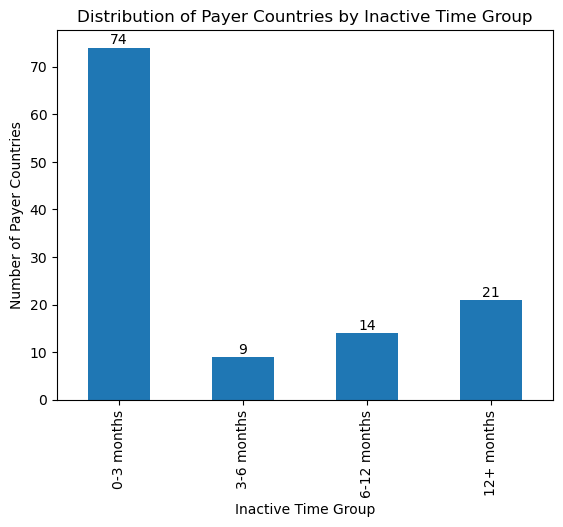

In [41]:
# Define the boundaries of age groups
bins = [0, 3, 6, 12, float('inf')]

# Create a new column 'age_group' in the result DataFrame
result['inactive_time_group'] = pd.cut(result['inactive_time'], bins, labels=['0-3 months', '3-6 months', '6-12 months', '12+ months'])

# Group by 'age_group' and count the number of 'payer_country' in each group
grouped_data = result.groupby('inactive_time_group')['payer_country'].count()

# Create the bar plot
fig, ax = plt.subplots()
bars = grouped_data.plot(kind='bar', ax=ax)

# Display the count values on top of each bar
for bar in bars.patches:
    yval = bar.get_height()
    xval = bar.get_x() + bar.get_width() / 2
    ax.text(xval, yval + 0.1, int(yval), ha='center', va='bottom')

# Labeling and title of the plot
plt.xlabel('Inactive Time Group')
plt.ylabel('Number of Payer Countries')
plt.title('Distribution of Payer Countries by Inactive Time Group')

# Show the plot
plt.show()

In [42]:
control=result.loc[result.inactive_time>0]
control.shape
##114+146=260##

(118, 11)

In [ ]:
##HOW MANY PAYERS ARE OR WERE 6 MONTHS OLD OR OLDER##
##LLEGARON A TENER O TIENEN AL MENOS 6 MESES##

In [43]:
age_payer_6m_or_more= result.loc[result.age_payer>=6]
age_payer_6m_or_more.shape

(188, 11)

In [420]:
## ALWAYS ACTIVE PAYERS (114)##
##NOTAR QUE ESO IMPLICA QUE TIENEN LA MISMA EDAD QUE TIEMPO ACTIVOS Y QUE HASTA 23/10/2023 ESTAN ACTIVOS##

In [44]:
##SAME AGE AS ACTIVE TIME##
##RECORDAR QUE LA EDAD SE CALCULA A OCTUBRE 2023, POR LO QUE ESTÁN ACTIVOS A ESA FECHA##
##NOTAR QUE 114 SIEMPRE ACTIVAS A HOY  SE LE SUMAN LAS 146 INACTIVAS O QUE SU TIEMPO ACTIVOS ES MENOR A SU EDAD Y LLEGAMOS A LAS 260##
always_active_payers=result.loc[(result.age_payer==result.active_time)]
always_active_payers.shape

(113, 11)

In [45]:
##WHAT PERCENTAGE OF THE AMOUNT TRADED BETWEEN JANUARY 21 AND OCTOBER 23 ARE "ALWAYS ON" PAYERS##
##NOTAR QUE ESTOS 114 PAYERS MANEJAN EL 96.5% DE LAS VENTAS DE LOS ULTIMOS 34 MESES##
sum(always_active_payers.total_amount) / sum(result.total_amount) * 100

96.50791012846905

In [ ]:
##RULE 1: PAYER WITH INACTIVE TIME OF SIX MONTHS OR LESS AND AGE > = 3 MONTHS
##REGLA: PAYER CON TIEMPO INACTIVO DE SEIS MESES O MENOS Y CON EDAD > = 3 MESES##

In [46]:
control=result.loc[(result.age_payer>=3) & (result.inactive_time<=3)]

In [ ]:
##RULE 2: PAYER WITH TRADED AMOUNT OF AT LEAST 10000 USD

In [47]:
control2=control.loc[control.total_amount>=10000]

In [48]:
control.shape, control2.shape

((159, 11), (137, 11))

In [49]:
control.total_amount.sum()/df.amount.sum()

0.9681190897149056

In [50]:
control3=control.loc[control.total_amount<=10000]

In [51]:
control3.shape

(22, 11)

In [52]:
control3

,payer_country,first_date,last_date,total_amount,total_transactions,age_payer,active_time,inactive_time,age_group,active_time_group,inactive_time_group
180,TRANSFERTO - THUNES_LITHUANIA,2023-05-28,2023-08-01,8600.00,5,4.87,2.17,2.70,3-6 months,0-3 months,0-3 months
1,7 ELEVEN (UT)_MEXICO,2020-12-31,2023-10-08,8019.49,175,34.13,33.70,0.43,12+ months,12+ months,0-3 months
184,TRANSFERTO - THUNES_NETHERLANDS,2022-09-15,2023-09-30,7909.47,8,13.37,12.67,0.70,12+ months,12+ months,0-3 months
177,TRANSFERTO - THUNES_IRELAND,2022-09-17,2023-10-11,7397.04,12,13.30,12.97,0.33,12+ months,12+ months,0-3 months
51,BNB_SENEGAL,2023-04-14,2023-10-21,6222.33,44,6.33,6.33,0.00,6-12 months,6-12 months,NaN
129,NAFA_CAMEROON,2022-11-30,2023-09-19,5386.49,6,10.83,9.77,1.07,6-12 months,6-12 months,0-3 months
196,TRANSFERTO - THUNES_SWITZERLAND,2022-06-16,2023-10-03,4932.60,31,16.40,15.80,0.60,12+ months,12+ months,0-3 months
197,TRANSFERTO - THUNES_TANZANIA,2022-03-16,2023-08-10,3085.00,6,19.47,17.07,2.40,12+ months,12+ months,0-3 months
163,TRANSFERTO - THUNES_AUSTRIA,2022-07-19,2023-10-21,2683.32,6,15.30,15.30,0.00,12+ months,12+ months,NaN
169,TRANSFERTO - THUNES_ETHIOPIA,2022-05-20,2023-10-11,2650.01,10,17.30,16.97,0.33,12+ months,12+ months,0-3 months


In [547]:
###FINAL RULE: PAYERS WITH NO MORE THAN 3 MONTHS INACTIVE AND NO LESS THAN 3 MONTHS OLD AND WHO WILL OPERATE AT LEAST 10,000 USD SINCE THE BEGINNING OF THEIR ACTIVITY OR SINCE JANUARY 2021.
###REGLA FINAL: PAYERS CON NO MAS DE 3 MESES INACTIVOS Y NO MENOS DE 3 MESES DE ANTIGUEDAD Y QUE OPERARAN AL MENOS 10000 USD DESDE EL INICIO DE SU ACTIVIDAD  O DESDE ENERO DE 2021##
## Y QUE TENGAN AL MENOS 50 transacciones##

In [53]:
final_universe=result.loc[(result.age_payer>=3) & (result.inactive_time<=3) & (result.total_amount>10000) & (result.total_transactions>50)]

In [54]:
final_universe.tail()

,payer_country,first_date,last_date,total_amount,total_transactions,age_payer,active_time,inactive_time,age_group,active_time_group,inactive_time_group
52,BNB_SIERRA LEONE,2023-05-22,2023-10-21,26127.60,115,5.07,5.07,0.00,3-6 months,3-6 months,NaN
160,TIGO MONEY_EL SALVADOR,2021-01-16,2023-10-21,25279.00,167,33.60,33.60,0.00,12+ months,12+ months,NaN
127,MUTHOOT_INDIA,2023-04-26,2023-10-21,21212.81,53,5.93,5.93,0.00,3-6 months,3-6 months,NaN
97,JMMB_JAMAICA,2023-05-05,2023-10-21,16487.20,142,5.63,5.63,0.00,3-6 months,3-6 months,NaN
50,BNB_LIBERIA,2023-05-19,2023-10-20,14483.00,73,5.17,5.13,0.03,3-6 months,3-6 months,0-3 months


In [55]:
final_universe.shape

(131, 11)

In [56]:
final_universe.payer_country.nunique()

131

In [57]:
final_universe.total_amount.sum()/df.amount.sum()

0.9681126736578183

In [83]:
final_universe.total_amount.sum()

24309913777.781002

In [ ]:
##THESE 135 PAYERS REPRESENT 98.15% OF THE TOTAL AMOUNT TRANSACTED FROM JANUARY THROUGH OCTOBER 2023.

In [58]:
final_universe.describe()

,first_date,last_date,total_amount,total_transactions,age_payer,active_time,inactive_time
count,131,131,1.310000e+02,1.310000e+02,131.000000,131.000000,131.000000
mean,2021-07-26 14:39:23.358778624,2023-10-18 13:11:27.022900736,1.855719e+08,4.471782e+05,27.210992,27.129542,0.081450
min,2020-12-31 00:00:00,2023-08-01 00:00:00,1.448300e+04,5.300000e+01,5.070000,5.070000,0.000000
25%,2020-12-31 00:00:00,2023-10-21 00:00:00,3.348048e+05,9.330000e+02,18.115000,18.085000,0.000000
50%,2020-12-31 00:00:00,2023-10-21 00:00:00,1.266389e+07,2.398000e+04,34.130000,34.030000,0.000000
75%,2022-04-25 12:00:00,2023-10-21 00:00:00,7.250825e+07,2.199195e+05,34.130000,34.130000,0.000000
max,2023-05-22 00:00:00,2023-10-21 00:00:00,6.397947e+09,1.470786e+07,34.130000,34.130000,2.700000
std,NaN,NaN,7.040251e+08,1.605211e+06,9.615606,9.610659,0.368534


In [ ]:
##WHAT PERCENTAGE OF THE TOTAL AMOUNT TRADED BETWEEN OCTOBER 23 AND JULY 23 DO THE SELECTED CASES REPRESENT?

In [49]:
###CORTAMOS LOS ULTIMOS 3 MESES DE DATOS Y LOS UNIMOS POR PAYER_COUNTRY AL UNIVERSO Y ANALIZAMOS EL PORCENTAJE DE MONTO QUE QUEDA AFUERA##

In [59]:
df_last3m= df.loc[(df.date>='2023-07-21') & (df.date<='2023-10-21')]
df_last3m.payer_country.nunique()

187

In [60]:
df_last3m.shape

(9850, 7)

In [61]:
df_last3m.payer_country.nunique()

187

In [62]:
df_last3m.head()

,payer,country,date,amount,count,payer_country,payer_country_encoder
3,MICOOPE-FENACOAC (RED CHAPINA),GUATEMALA,2023-10-10,121599.94,197,MICOOPE-FENACOAC (RED CHAPINA)_GUATEMALA,124
6,VIAMERICAS USA DEPOSITS,UNITED STATES,2023-08-24,62990.04,132,VIAMERICAS USA DEPOSITS_UNITED STATES,220
7,BANCO GANADERO (BOLIVIA),BOLIVIA,2023-08-19,6666.54,17,BANCO GANADERO (BOLIVIA)_BOLIVIA,26
11,CUSCA (CITI - RECIBA NETWORKS),EL SALVADOR,2023-09-02,359568.00,1394,CUSCA (CITI - RECIBA NETWORKS)_EL SALVADOR,65
18,COOPERATIVA CACIL (UT),HONDURAS,2023-08-23,13055.00,26,COOPERATIVA CACIL (UT)_HONDURAS,61


In [63]:
df_merge_control=pd.merge(df_last3m,final_universe, on='payer_country', how='left',indicator=True)

In [64]:
df_merge_control._merge.value_counts()

_merge
both          9695
left_only      155
right_only       0
Name: count, dtype: int64

In [ ]:
##QUE PORCENTAJE DEL MONTO OPERADO EN EL PERIODO QUEDA AFUERA CON ESE UNIVERSO??##

In [65]:
df_merge_control.amount.sum()

3306737105.6973996

In [66]:
df_merge_control.payer_country.nunique()

187

In [67]:
df_merge_control2=df_merge_control.loc[df_merge_control._merge=='left_only']
df_merge_control2.amount.sum()

47804.35

In [ ]:
##PORCENTAJE DE MONTO OPERADO POR PAYERS EN EL "UNIVERSO FINAL" SOBRE EL MONTO TOTAL OPERADO EN LOS ULTIMOS 3 MESES##

In [68]:
(df_merge_control2.amount.sum()/df_merge_control.amount.sum())*100

0.0014456652728042597

In [69]:
df_merge_control3=df_merge_control.loc[df_merge_control._merge=='both']
df_merge_control3.amount.sum()

3306689301.3474

In [70]:
df_merge_control3.payer_country.nunique()

131

In [71]:
df_merge_control3.country.nunique()

45

In [72]:
##135 PAYERS CONCENTRAN EL 99.9% DEL MONTO OPERADO EN LOS ULTIMOS 3 MESES DESDE EL 21 DE OCTUBRE DE 2023##

In [73]:
df_merge_control3.country.unique()

array(['GUATEMALA', 'UNITED STATES', 'BOLIVIA', 'EL SALVADOR', 'HONDURAS',
       'MEXICO', 'NEPAL', "COTE D'IVOIRE (IVORY COAST)", 'BURKINA FASO',
       'INDONESIA', 'ARGENTINA', 'SIERRA LEONE', 'PERU', 'FRANCE',
       'CAMEROON', 'BANGLADESH', 'CHILE', 'GAMBIA, THE', 'GUINEA', 'TOGO',
       'ECUADOR', 'PHILIPPINES', 'GERMANY', 'LIBERIA', 'SPAIN',
       'COSTA RICA', 'GHANA', 'MALAYSIA', 'NICARAGUA', 'BRAZIL',
       'NIGERIA', 'INDIA', 'BELGIUM', 'COLOMBIA', 'HAITI',
       'DOMINICAN REPUBLIC', 'UNITED STATES (ATM & DEPOSITS)', 'SENEGAL',
       'PORTUGAL', 'JAMAICA', 'UNITED KINGDOM', 'MALI', 'ITALY', 'BENIN',
       'THAILAND'], dtype=object)

In [74]:
country_usd=['EL SALVADOR', 'UNITED STATES', 'ECUADOR']

In [75]:
df_usd=df_merge_control3[df_merge_control3['country'].isin(country_usd)]

In [76]:
df_usd.amount.sum()/df_merge_control3.amount.sum()

0.05881917232464115

In [77]:
df_usd.payer_country.nunique()

18

In [78]:
df_merge_control4=df_merge_control3.loc[:, ['country', 'amount']]

In [79]:
df_amount_country=df_merge_control4.groupby('country').sum()

In [80]:
df_amount_country.sort_values('amount', ascending=False)

,amount
country,
MEXICO,1.785266e+09
GUATEMALA,7.436570e+08
HONDURAS,1.904964e+08
EL SALVADOR,1.332057e+08
BRAZIL,8.362096e+07
PHILIPPINES,7.862193e+07
COLOMBIA,7.104991e+07
NICARAGUA,7.089073e+07
ECUADOR,5.055975e+07


In [81]:
total_amount = df_amount_country['amount'].sum()
df_amount_country['percentage'] = (df_amount_country['amount'] / total_amount) * 100

In [82]:
df_amount_country.sort_values('amount', ascending=False)

,amount,percentage
country,,
MEXICO,1.785266e+09,53.989537
GUATEMALA,7.436570e+08,22.489473
HONDURAS,1.904964e+08,5.760939
EL SALVADOR,1.332057e+08,4.028371
BRAZIL,8.362096e+07,2.528842
PHILIPPINES,7.862193e+07,2.377663
COLOMBIA,7.104991e+07,2.148672
NICARAGUA,7.089073e+07,2.143858
ECUADOR,5.055975e+07,1.529014


In [72]:
###ACTIVOS A ALGUN MES SELECCIONADO##
df_control= df.loc[(df.date>='2023-09-30') & (df.date<='2023-10-21')]
df_control.payer_country.nunique()

173